In [5]:
import numpy as np
import pandas as pd

path_dir = ['12-收入-学历-资产-负债.csv','14-收入-学历-资产-负债.csv','16-收入-学历-资产-负债.csv','18-收入-学历-资产-负债.csv','20-收入-学历-资产-负债.csv','22-收入-学历-资产-负债.csv']

# 创建字典存储所有年份的DataFrame
year_dfs = {}

for path in path_dir:
    # 从文件名提取年份（前两位数字）
    year = '20' + path[:2]  # 例如 '12' -> '2012'
    
    # 读取CSV并存入字典
    try:
        df = pd.read_csv(path)
        year_dfs[year] = df
        
        # 打印基本信息
        print(f"\n=== 已加载 {year} 年数据 ===")
        print(f"行数: {len(df)}, 列数: {len(df.columns)}")
        
    except Exception as e:
        print(f"加载 {year} 年数据失败: {str(e)}")

# 数据清洗函数
def clean_data(df, income_col, id_col):
    """
    清洗数据：去除 NaN、重复家庭记录、负收入或零收入记录
    参数:
        df: 输入 DataFrame
        income_col: 收入列名
        id_col: 家庭标识列名
    返回:
        清洗后的 DataFrame
    """
    # 去除 NaN
    df_clean = df[[income_col, id_col]].dropna()

    # 去除重复的家庭记录（基于 id_col 保留第一条记录）
    df_clean = df_clean.drop_duplicates(subset=[id_col], keep='first')

    # 只保留收入大于 0 的记录
    df_clean = df_clean[df_clean[income_col] > 0]

    return df_clean

# 通胀调整：定义通胀率
inflation_rates = {
    2013: 0.0262,
    2014: 0.0192,
    2015: 0.0144,
    2016: 0.0200,
    2017: 0.0159,
    2018: 0.0207,
    2019: 0.0290,
    2020: 0.0242,
    2021: 0.0098,
    2022: 0.0197
}

# 计算累计通胀因子（2022年物价相对于2012年的倍数）
cumulative_factor = 1.0
for year, rate in inflation_rates.items():
    cumulative_factor *= (1 + rate)

# 假设 year_dfs 字典已包含清洗后的 2012 和 2022 数据
# 如果没有，需要先加载和清洗
# 确保 'fincome1', 'fid12', 'fid22' 列存在
df_2012_clean = clean_data(year_dfs['2012'], 'fincome1', 'fid12')
df_2022_clean = clean_data(year_dfs['2022'], 'fincome1', 'fid22')

# 通胀调整：将2022年收入调整到2012年可比价格
df_2022_clean['fincome1_2012_comparable'] = df_2022_clean['fincome1'] / cumulative_factor

# 相对分布计算
# 计算中位数
median_2012 = df_2012_clean['fincome1'].median()
median_2022_comparable = df_2022_clean['fincome1_2012_comparable'].median()

# 计算中位数位移
rho = median_2022_comparable - median_2012

# 获取2012年排序后的收入数组
incomes_2012_sorted = np.sort(df_2012_clean['fincome1'].values)
n_2012 = len(incomes_2012_sorted)

# 获取2022年可比收入数组
incomes_2022_comparable = df_2022_clean['fincome1_2012_comparable'].values
n_2022 = len(incomes_2022_comparable)

# 计算调整后的2022年收入（移除中位数位移）
adjusted_incomes_2022 = incomes_2022_comparable - rho

# 计算相对位置（分位数秩）
r_i = np.searchsorted(incomes_2012_sorted, adjusted_incomes_2022, side='right') / n_2012

# 计算相对极化指数 (MRP)
MRP = (4 / n_2022) * np.sum(np.abs(r_i - 0.5)) - 1

# 对 r_i 排序
r_sorted = np.sort(r_i)

# 计算下层和上层极化指数
n_half = n_2022 // 2
LRP = (8 / n_2022) * np.sum(0.5 - r_sorted[:n_half]) - 1
URP = (8 / n_2022) * np.sum(r_sorted[-n_half:] - 0.5) - 1

# 输出结果
print(f"累计通胀因子（2022年相对于2012年）：{cumulative_factor:.2%}")
print(f"2012年家庭收入中位数：{median_2012:.2f} 元")
print(f"2022年家庭收入中位数（2012年可比价格）：{median_2022_comparable:.2f} 元")
print(f"相对极化指数 (MRP)：{MRP:.4f}")
print(f"下层相对极化指数 (LRP)：{LRP:.4f}")
print(f"上层相对极化指数 (URP)：{URP:.4f}")

# 相对分布计算函数
def calculate_relative_distribution(df_base, income_col_base, id_col_base,
                                  df_comp, income_col_comp, id_col_comp,
                                  base_year, comp_year, inflation_dict):
    """
    计算相对分布指数（MRP、LRP、URP）以比较两个年份的收入分布。

    参数:
        df_base (pandas.DataFrame): 基准年份的数据。
        income_col_base (str): 基准年份 DataFrame 中的收入列名。
        id_col_base (str): 基准年份 DataFrame 中的家庭标识列名。
        df_comp (pandas.DataFrame): 比较年份的数据。
        income_col_comp (str): 比较年份 DataFrame 中的收入列名。
        id_col_comp (str): 比较年份 DataFrame 中的家庭标识列名。
        base_year (int): 基准年份（例如 2012）。
        comp_year (int): 比较年份（例如 2022）。
        inflation_dict (dict): 键为年份（int），值为该年相对于前一年的通胀率（float）。
                              应包含从 base_year+1 到 comp_year 的所有年份。

    依赖:
        - numpy (as np)
        - pandas (as pd)
        - clean_data 函数（用于数据清洗）

    返回:
        dict: 包含以下键值对的字典：
            - 'MRP': 相对极化指数
            - 'LRP': 下层相对极化指数
            - 'URP': 上层相对极化指数
            - 'median_base': 基准年份清洗后收入的中位数
            - 'median_comp_comparable': 比较年份经通胀调整后的可比收入中位数
            - 'rho': 中位数位移 (median_comp_comparable - median_base)
            - 'cumulative_inflation_factor': 累计通胀因子（comp_year 相对于 base_year）
            - 'n_base_clean': 清洗后基准年样本量
            - 'n_comp_clean': 清洗后比较年样本量

    说明:
        - 调用 clean_data 清洗输入数据。
        - 根据 inflation_dict 计算累计通胀因子。
        - 将比较年份的收入调整到基准年可比价格。
        - 计算相对分布指数（MRP、LRP、URP）及相关统计量。
    """
    # 数据清洗
    df_base_clean = clean_data(df_base, income_col_base, id_col_base)
    df_comp_clean = clean_data(df_comp, income_col_comp, id_col_comp)

    # 获取清洗后样本量
    n_base_clean = len(df_base_clean)
    n_comp_clean = len(df_comp_clean)

    # 计算累计通胀因子
    cumulative_factor = 1.0
    for year in range(base_year + 1, comp_year + 1):
        if year not in inflation_dict:
            raise ValueError(f"通胀率字典缺少 {year} 年的数据")
        cumulative_factor *= (1 + inflation_dict[year])

    # 通胀调整：将比较年份收入调整到基准年可比价格
    comparable_income_col = f'{income_col_comp}_comparable'
    df_comp_clean[comparable_income_col] = df_comp_clean[income_col_comp] / cumulative_factor

    # 计算中位数
    median_base = df_base_clean[income_col_base].median()
    median_comp_comparable = df_comp_clean[comparable_income_col].median()

    # 计算中位数位移
    rho = median_comp_comparable - median_base

    # 获取基准年排序后的收入数组
    incomes_base_sorted = np.sort(df_base_clean[income_col_base].values)

    # 获取比较年可比收入数组
    incomes_comp_comparable = df_comp_clean[comparable_income_col].values

    # 计算调整后的比较年收入（移除中位数位移）
    adjusted_incomes_comp = incomes_comp_comparable - rho

    # 计算相对位置（分位数秩）
    r_i = np.searchsorted(incomes_base_sorted, adjusted_incomes_comp, side='right') / n_base_clean

    # 计算相对极化指数 (MRP)
    MRP = (4 / n_comp_clean) * np.sum(np.abs(r_i - 0.5)) - 1

    # 对 r_i 排序
    r_sorted = np.sort(r_i)

    # 计算下层和上层极化指数
    n_half = n_comp_clean // 2
    LRP = (8 / n_comp_clean) * np.sum(0.5 - r_sorted[:n_half]) - 1
    URP = (8 / n_comp_clean) * np.sum(r_sorted[-n_half:] - 0.5) - 1

    # 返回结果字典
    return {
        'MRP': MRP,
        'LRP': LRP,
        'URP': URP,
        'median_base': median_base,
        'median_comp_comparable': median_comp_comparable,
        'rho': rho,
        'cumulative_inflation_factor': cumulative_factor,
        'n_base_clean': n_base_clean,
        'n_comp_clean': n_comp_clean
    }


# 假设 year_dfs 字典已包含清洗后的 2012 和 2022 数据
# 再次调用函数计算
try:
    result = calculate_relative_distribution(
        df_base=year_dfs['2012'],
        income_col_base='fincome1',
        id_col_base='fid12',
        df_comp=year_dfs['2022'],
        income_col_comp='fincome1',
        id_col_comp='fid22',
        base_year=2012,
        comp_year=2022,
        inflation_dict=inflation_rates
    )

    # 打印结果
    print("相对分布计算结果：")
    for key, value in result.items():
        if key in ['MRP', 'LRP', 'URP']:
            print(f"{key}: {value:.4f}")
        elif key in ['median_base', 'median_comp_comparable', 'rho']:
            print(f"{key}: {value:.2f} 元")
        elif key == 'cumulative_inflation_factor':
            print(f"{key}: {value:.2%}")
        else:
            print(f"{key}: {value}")

except NameError:
    print("示例调用失败：请确保 year_dfs 字典已定义")
except KeyError as e:
    print(f"示例调用失败: 缺少必要的列或年份数据 - {e}")
except Exception as e:
    print(f"计算相对分布时出错: {e}")

C:\Anaconda\envs\DL2\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



=== 已加载 2012 年数据 ===
行数: 1048575, 列数: 19

=== 已加载 2014 年数据 ===
行数: 54976, 列数: 18

=== 已加载 2016 年数据 ===
行数: 56870, 列数: 18

=== 已加载 2018 年数据 ===
行数: 58053, 列数: 18

=== 已加载 2020 年数据 ===
行数: 51073, 列数: 18

=== 已加载 2022 年数据 ===
行数: 47033, 列数: 19
累计通胀因子（2022年相对于2012年）：121.77%
2012年家庭收入中位数：29530.00 元
2022年家庭收入中位数（2012年可比价格）：65694.97 元
相对极化指数 (MRP)：0.3542
下层相对极化指数 (LRP)：0.4883
上层相对极化指数 (URP)：0.2200
相对分布计算结果：
MRP: 0.3542
LRP: 0.4883
URP: 0.2200
median_base: 29530.00 元
median_comp_comparable: 65694.97 元
rho: 36164.97 元
cumulative_inflation_factor: 121.77%
n_base_clean: 11605
n_comp_clean: 10560


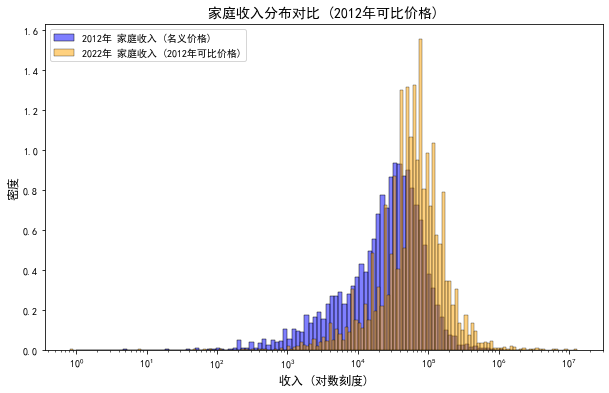

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 df_2012_clean 和 df_2022_clean 已准备好
# 并且 df_2022_clean 包含 'fincome1_2012_comparable' 列

plt.rcParams['font.sans-serif'] = ['SimHei'] # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

# 设置图形大小
plt.figure(figsize=(10, 6))

# 使用 seaborn.histplot 绘制密度直方图
sns.histplot(
    data=df_2012_clean,
    x='fincome1',
    stat='density',
    color='blue',
    alpha=0.5,
    label='2012年 家庭收入 (名义价格)',
    log_scale=True # 使用对数刻度
)

sns.histplot(
    data=df_2022_clean,
    x='fincome1_2012_comparable',
    stat='density',
    color='orange',
    alpha=0.5,
    label='2022年 家庭收入 (2012年可比价格)',
    log_scale=True # 使用对数刻度
)

# 设置标题和轴标签
plt.title('家庭收入分布对比 (2012年可比价格)', fontsize=14)
plt.xlabel('收入 (对数刻度)', fontsize=12)
plt.ylabel('密度', fontsize=12)

# 显示图例
plt.legend()

# 保存图表
plt.savefig('income_distribution_zh.png', dpi=300, bbox_inches='tight')

# 显示图表
plt.show()

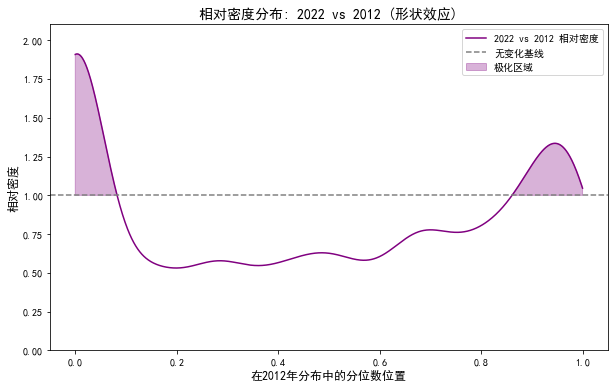

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 假设 r_i 数组已在上面 calculate_relative_distribution 中计算得到

plt.rcParams['font.sans-serif'] = ['SimHei'] # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

try:
    # 检查 r_i 是否存在
    if 'r_i' not in locals():
        raise NameError("错误: 变量 'r_i' 未定义，请先运行 calculate_relative_distribution 部分。")

    # 估计 r_i 的核密度
    kde = gaussian_kde(r_i)

    # 生成 [0, 1] 范围的等间隔点
    r_values = np.linspace(0, 1, 1000)
    relative_density = kde(r_values)

    # 设置图形大小
    plt.figure(figsize=(10, 6))

    # 绘制相对密度曲线
    plt.plot(r_values, relative_density, label='2022 vs 2012 相对密度', color='purple')

    # 添加 y=1 的水平虚线
    plt.axhline(y=1, color='gray', linestyle='--', label='无变化基线')

    # 填充相对密度大于 1 的区域
    plt.fill_between(
        r_values,
        relative_density,
        1,
        where=(relative_density > 1),
        color='purple',
        alpha=0.3,
        label='极化区域'
    )

    # 设置标题和轴标签
    plt.title('相对密度分布: 2022 vs 2012 (形状效应)', fontsize=14)
    plt.xlabel('在2012年分布中的分位数位置', fontsize=12)
    plt.ylabel('相对密度', fontsize=12)

    # 设置 y 轴范围
    plt.ylim(0, max(relative_density) * 1.1)

    # 显示图例
    plt.legend()

    # 保存图表
    plt.savefig('relative_density_zh.png', dpi=300, bbox_inches='tight')

    # 显示图表
    plt.show()

except NameError as ne:
    print(ne)
except Exception as e:
    print(f"绘制相对密度图时出错: {e}")